# 'Optimal' Decision-Making
Mihir Singh

## Abstract
The purpose of this blog post was to create a decision system that maximizes the profit a bank will earn as well investigate the implications of this decision system on individual borrowers. I first investigated the data to find some general underlying trends before building a model that could predict the probability someone would repay a loan (which is the score for an individual). With the model built, I then found the threshold probability of repayment (ie threshold score) for the model's prediction that would optimize the profit of the bank. I then investigated the implications of this threshold on individual borrowers by comparing score to age and income level as well as looking at the variation in the approval and repayment rates of different types of loans. The model maximized profit with a a threshold at a score of 0.53 and ultimately earned the bank $7697437.56. The model's score was influenced by factors such as age, income level, and loan type.

# Grabbing the Data
Before we start, we need to first import the training data. Our target variable will be 'loan_status.'

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# read in data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train.head()

# adjust plot format
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

## Exploring the Data
Now that we have some data to work with, let's try and find some patterns. We can start by creating a summary table comparing the avereage loan amount by homeownership status of an individual.  

In [8]:
summaryTable = df_train.groupby(['person_home_ownership']).aggregate(Loan_Average =('loan_amnt', 'mean'))
print(summaryTable)

                       Loan_Average
person_home_ownership              
MORTGAGE               10562.137462
OTHER                  11235.795455
OWN                     8978.912626
RENT                    8843.507973


We see here that those who have a mortgage have the highest average loan amount. This could be due to the fact that those with a mortgage have a higher income and are more likely to be approved for a larger loan. However, the largest loan average was for those whose home ownership status was 'other.' This could be students with loans for educational purposes living in college dorms.

We can also compare an individual's age and their loan amount. To do this we will group individuals into quartiles.

average loan amt by age_quartile
20 to 23.0      8790.989412
23.0 to 26.0    9739.076064
26.0 to 30.0    9967.734319
30.0 to 123     9889.924230
Name: loan_amnt, dtype: float64


/Users/mihirsingh/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/var/folders/fv/_v7myjl904983sbb39qbkzw40000gn/T/ipykernel_32471/2138611228.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("average loan amt by", df_train_age_copy.groupby('age_quartile')['loan_amnt'].mean())


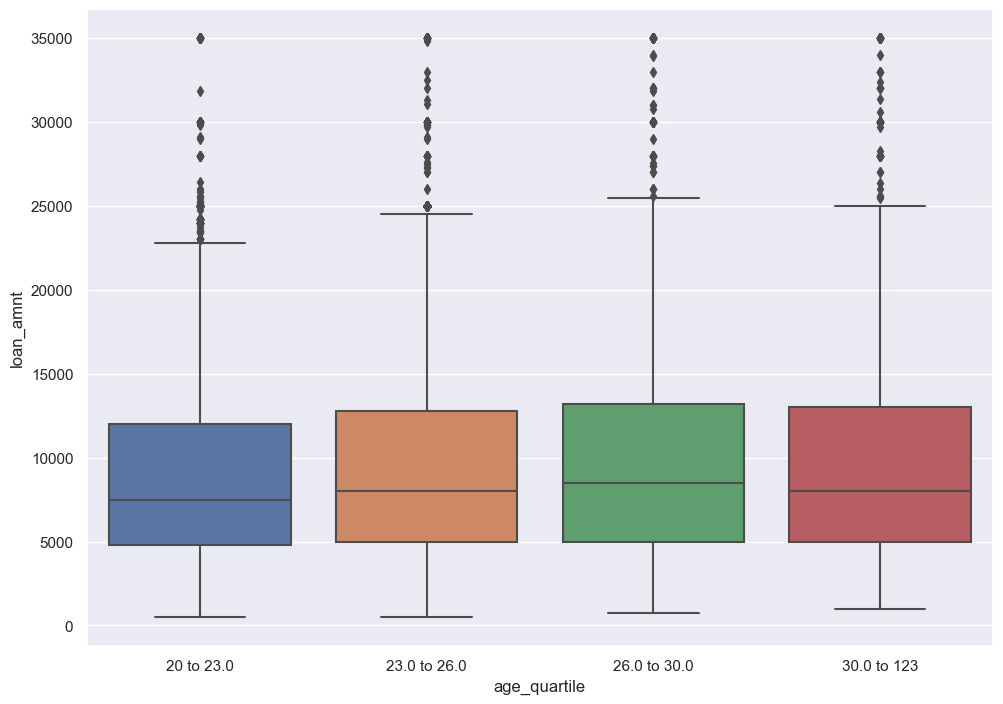

In [9]:
# there is someone 144 years old - might get rid of that outlier
df_train_age_copy = df_train.copy()
df_train_age_copy = df_train_age_copy[df_train_age_copy['person_age'] != 144]

# group individuals into quartiles by age
quartiles = df_train_age_copy['person_age'].quantile([0.25, 0.5, 0.75])
firstQuartile = f"{df_train_age_copy['person_age'].min()} to {quartiles[0.25]}"
secondQuartile = f"{quartiles[0.25]} to {quartiles[0.50]}"
thirdQuartile = f"{quartiles[0.50]} to {quartiles[0.75]}"
fourthQuartile = f"{quartiles[0.75]} to {df_train_age_copy['person_age'].max()}"

# separate individuals into quartiles
df_train_age_copy['age_quartile'] = pd.qcut(df_train['person_age'], q = [0, 0.25, 0.5, 0.75, 1], labels = [firstQuartile, secondQuartile, thirdQuartile, fourthQuartile])

# plot
sns.boxplot(df_train_age_copy, x='age_quartile', y='loan_amnt')
print("average loan amt by", df_train_age_copy.groupby('age_quartile')['loan_amnt'].mean())

While there is a slight variation between the loan amounts and age, it is not that strong. It is also interesting to note that the data includes someone who is 144 years old (though this is probably an error). This outlier was removed from the data for this plot. 

We might not have been able to find a strong correlation between age and loan amount, but we might have better luck looking at whether those who have been employed for a longer period of time are more likely to have a large line of credit. Like before, we will group individuals into quartiles based on employment length.

average loan amt by employment length employment_length_quartile
0.0 to 2.0       8940.104406
2.0 to 4.0       9423.175327
4.0 to 7.0       9783.332000
7.0 to 123.0    10805.937675
Name: loan_amnt, dtype: float64
123.0


/Users/mihirsingh/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/var/folders/fv/_v7myjl904983sbb39qbkzw40000gn/T/ipykernel_32471/1445965932.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("average loan amt by employment length", df_train_work_copy.groupby('employment_length_quartile')['loan_amnt'].mean())


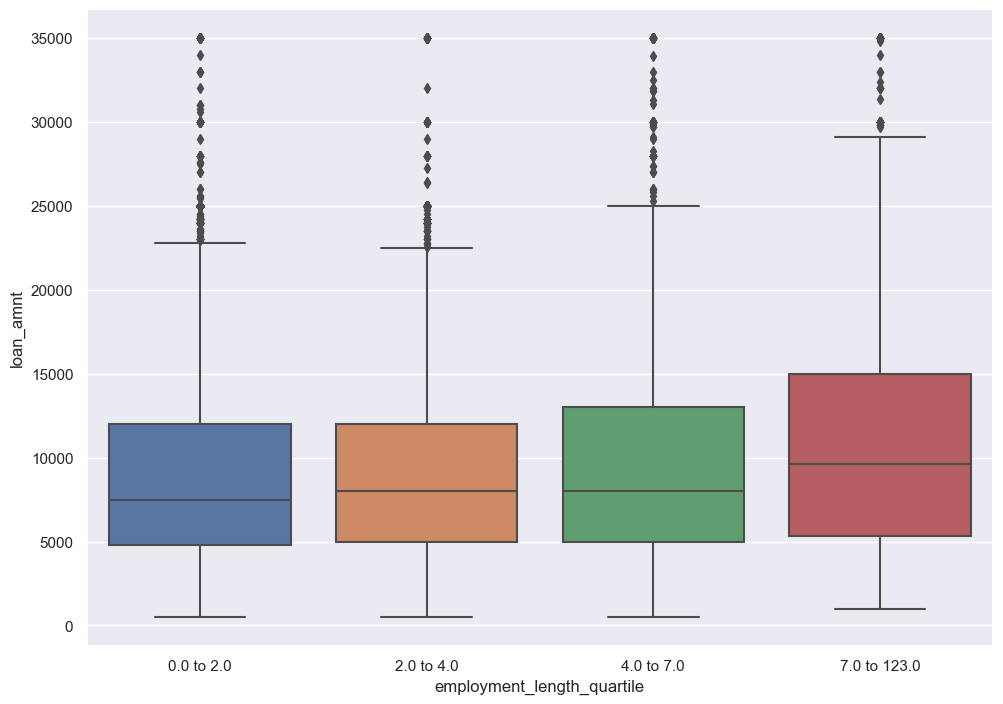

In [10]:
# there is someone working for 144 years - might get rid of that outlier
df_train_work_copy = df_train.copy()
df_train_work_copy = df_train_work_copy[df_train_work_copy['person_emp_length'] != 144]

# group individuals into quartiles by age
quartiles = df_train_work_copy['person_emp_length'].quantile([0.25, 0.5, 0.75])
firstQuartile = f"{df_train_work_copy['person_emp_length'].min()} to {quartiles[0.25]}"
secondQuartile = f"{quartiles[0.25]} to {quartiles[0.50]}"
thirdQuartile = f"{quartiles[0.50]} to {quartiles[0.75]}"
fourthQuartile = f"{quartiles[0.75]} to {df_train_work_copy['person_emp_length'].max()}"

# separate individuals into quartiles
df_train_work_copy['employment_length_quartile'] = pd.qcut(df_train_work_copy['person_emp_length'], q = [0, 0.25, 0.5, 0.75, 1], labels = [firstQuartile, secondQuartile, thirdQuartile, fourthQuartile])

# plot
sns.boxplot(df_train_work_copy, x='employment_length_quartile', y='loan_amnt')
print("average loan amt by employment length", df_train_work_copy.groupby('employment_length_quartile')['loan_amnt'].mean())
df_train_work_copy['employment_length_quartile'] = pd.qcut(df_train_work_copy['person_emp_length'], q = [0, 0.25, 0.5, 0.75, 1], labels = [firstQuartile, secondQuartile, thirdQuartile, fourthQuartile])
print(df_train_work_copy['person_emp_length'].max())


Loan amount does slightly increase over time as employment length increased. This increase is generally pretty small, but is most prominent when someone has been working for 7+ years.

# Building a Model
Now that we have explored the data and have a general understanding of what we are working with, we can begin creating a model that predicts whether a prospective borrower is likely to default on a given loan.

We will first get rid of our 'loan grade' column from the data as well as the aged 144 individual since this person is an outlier. Then we will implement logistic regression and cross validate the model. We will have a model based on 5 features, since we don't want to include too many and overfit our model.

In [11]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# get rid of target column and outlier
df_model = df_train.copy()
df_model.drop(columns = 'loan_grade', inplace = True)
df_model = df_model[df_model['person_age'] != 144]

# get list of all features
column_names = list(df_model.columns)
df_model = df_model[column_names]

# need to encode features so we can actually use logistic regression
# cb, loan intent, encoding type of home ownership
encoder = LabelEncoder()
encoder.fit(df_model['cb_person_default_on_file'])
df_model['cb_person_default_on_file'] = encoder.transform(df_model['cb_person_default_on_file'])
encoder.fit(df_model['person_home_ownership'])
df_model['person_home_ownership'] = encoder.transform(df_model['person_home_ownership'])
encoder.fit(df_model['loan_intent'])
df_model['loan_intent'] = encoder.transform(df_model['loan_intent'])
df_model = df_model.dropna()
df_model['person_emp_length'] = df_model['person_emp_length'].astype(int)
df_model.head()

# train model based on five columns and choose best one
LRBest = 0
LRBestCols = []
column_names.remove('loan_status')
for features in combinations(column_names, 5):
    # logistic regression
    features = list(features)
    LR = LogisticRegression(max_iter=1000)
    LR.fit(df_model[features], df_model['loan_status'])
    scoreLR = LR.score(df_model[features], df_model['loan_status'])
    if scoreLR > LRBest:
      LRBest = scoreLR
      LRBestCols = features

# see what worked
print(LRBest, " ", LRBestCols)

# cross validate models
cv_scores_LR = cross_val_score(LR, df_model[features], df_model['loan_status'], cv=5)
print((cv_scores_LR).mean())

0.8462277331470486   ['person_age', 'person_home_ownership', 'person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length']
0.795973448332728


Our best 5 features seem to be age, home-ownership, employment-length, loan as a percent of income, and the length of a person's credit history. This seems to be doing a decent job of predicting whether a person will default on a loan.

Let's get our weight vector for our model.

In [12]:
# train model based on best features
LR.fit(df_model[LRBestCols], df_model['loan_status'])

# getting weight vector from our model
w = LR.coef_[0]
w

array([-8.07133566e-04,  3.36542470e-01, -1.99919415e-02,  7.93852091e+00,
       -1.88709181e-03])

## Finding a Threshold
Now that we have a weight vector and a model, we need to choose a threshold to determine whether a person is likely to default on a loan. We will use the following assumptions about how a bank makes/loses money:

1. if a loan is repaid in full, profit = loan_amnt * (1+0.25*loan_int_rate)^10 - loan_amnt
2. if an individual defaults, profit = loan_amnt * (1+0.25*loan_int_rate)^3 - 1.7*loan_amnt 

We will use these assumptions to determine the optimal threshold for our model. 

First, we should look at an Receiver Operating Characteristic (ROC) curve to visually see our model's performance at predicting whether or not an individual will default.

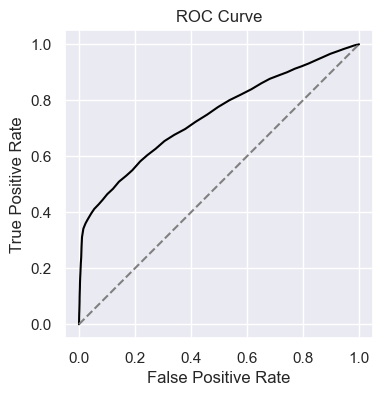

In [13]:
# computing and plotting ROC curve - from Professor Phil Chodrow
def linear_score(X, w):
    return X@w

s = linear_score(df_model[LRBestCols], w)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

num_thresholds = 101

FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)

T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
s    = linear_score(df_model[LRBestCols], w)

for i in range(num_thresholds):
    t = T[i]
    preds    = s >= t
    FPR[i]   = ((preds == 1) & (df_model['loan_status'] == 0)).sum() / (df_model['loan_status']  == 0).sum()
    TPR[i]   = ((preds == 1) & (df_model['loan_status'] == 1)).sum() / (df_model['loan_status']  == 1).sum()

ax.plot(FPR, TPR, color = "black")
ax.plot([0,1], [0,1], linestyle="--", color = "grey")
ax.set_aspect('equal')

labs = ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate", title = "ROC Curve")

The ROC curve does an ok job at predicting whether an individual will default. Ideally we would see the solid line curve farther towards the top left of the plot.

Now we can look at the expected gain as a function of the threshold. This curve will help us determine which threshold is optimal for our model.

However, in order to first do this, we need to calculate the profit the bank might make on a loan. This itself depends on the probability someone will repay or default.

In [14]:
# get probability of being paid and add to df
probabilityPaid = LR.predict_proba(df_model[LRBestCols])
df_model['probabilityPaid'] = probabilityPaid[:,0].tolist()

Now that we have the probability that someone will repay. We can calculate the profit for the bank for each individual. We will only look at people whose probability is above a certain threshold. From there, we will look and see if they defaulted or not and calculate the profit based off these values. 

In [15]:
def findProfitByThreshold(t, df_model):
    aboveThreshold = df_model[df_model['probabilityPaid'] > t].copy()
    paid = 0
    default = 0
    
    for i in range(aboveThreshold.shape[0]):
        if aboveThreshold.iloc[i]['loan_status'] == 0:
            loanAmnt = aboveThreshold.iloc[i]['loan_amnt']
            loanInt = aboveThreshold.iloc[i]['loan_int_rate']
            paid += loanAmnt*(1 + 0.25*(loanInt/100))**10 - loanAmnt 
        else:
            loanAmnt = aboveThreshold.iloc[i]['loan_amnt']
            loanInt = aboveThreshold.iloc[i]['loan_int_rate']
            default += loanAmnt*(1 + 0.25*(loanInt/100))**3 - 1.7*loanAmnt 
    return paid + default

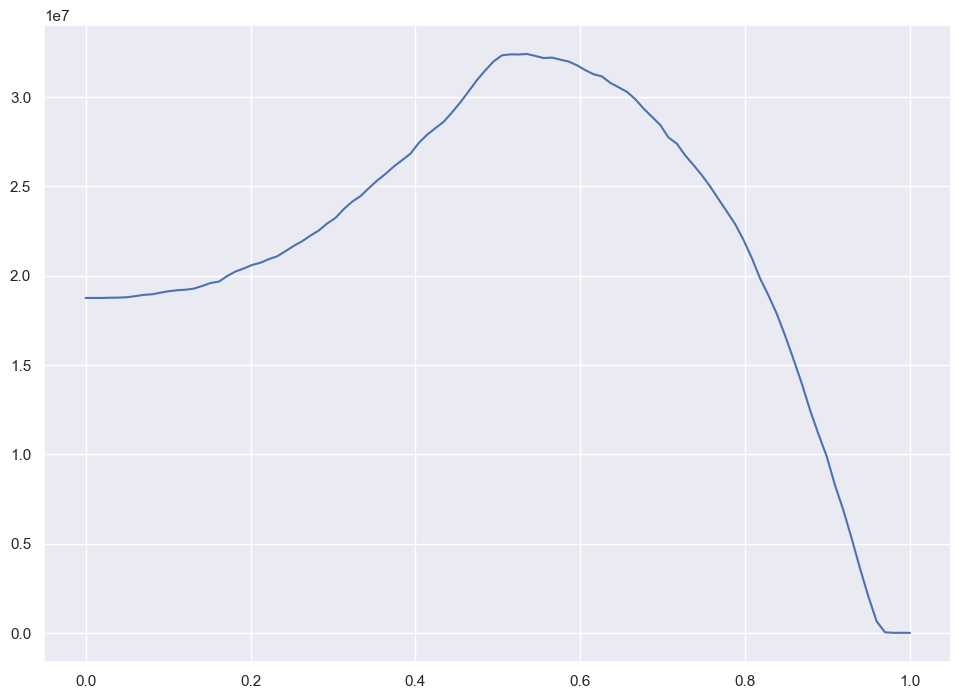

In [16]:
thresholds = np.linspace(0, 1, 100)
profits = []
for t in thresholds:
    profits.append(findProfitByThreshold(t, df_model))
plt.plot(thresholds, profits)

We see that our make profit occurs when we have a threshold around the 0.5 range. We can find the exact value by finding the maximum value of the curve.

In [17]:
# find best threshold
print(f"Max profit of ${max(profits)} at threshold = {profits.index(max(profits))/100}")
print(f"Max profit/borrower of ${max(profits)/len(df_model[df_model['probabilityPaid'] >= 0.53])}")

Max profit of $32406222.49662961 at threshold = 0.53
Max profit/borrower of $1566.9562640408883


So our best threshold is when the probability of repayment is 0.53. This is the point where the bank will make the most profit, earning $32406222.49.

## Evaluating Our Model from the Bank's Perspective
We will now evaluate our model on some test data. To do so, we will use the threshold we determined earlier of t=0.53. We will also have to encode the data before we can run our model.

In [18]:
# import data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

# remove loan  grade col
df_tc = df_test.copy()
df_tc.drop(columns = 'loan_grade', inplace = True)
df_tc = df_tc[df_tc['person_age'] != 144]

# need to encode features so we can actually use logistic regression
# cb, loan intent, encoding type of home ownership
encoder = LabelEncoder()
encoder.fit(df_tc['cb_person_default_on_file'])
df_tc['cb_person_default_on_file'] = encoder.transform(df_tc['cb_person_default_on_file'])
encoder.fit(df_tc['person_home_ownership'])
df_tc['person_home_ownership'] = encoder.transform(df_tc['person_home_ownership'])
encoder.fit(df_tc['loan_intent'])
df_tc['loan_intent'] = encoder.transform(df_tc['loan_intent'])
df_tc = df_tc.dropna()
df_tc['person_emp_length'] = df_tc['person_emp_length'].astype(int)
df_tc.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,42000,3,5,5,1000,15.58,1,0.02,0,4
1,32,51000,0,2,0,15000,11.36,0,0.29,0,9
2,35,54084,3,2,0,3000,12.61,0,0.06,0,6
3,28,66300,0,11,3,12000,14.11,1,0.15,0,6
4,22,70550,3,0,3,7000,15.88,1,0.08,0,3


With the data all set up, we can use our model.

In [19]:
# make predictions on probability individual will repay
probabilityPaid = LR.predict_proba(df_tc[LRBestCols])
df_tc['probabilityPaid'] = probabilityPaid[:,0].tolist()

# find profit
profit = findProfitByThreshold(0.53,df_tc)
print(f"profit is: {profit}")
print(f"profit per borrower is: {profit/len(df_tc[df_tc['probabilityPaid'] >= 0.53])}")

profit is: 7697437.566609849
profit per borrower is: 1500.4751591832064


At our threshold 0f 0.53, the bank will make a profit of $7697437.56 with a profit per borrower of $1500.

## Evaluating Our Model from the Borrower's Perspective
After looking at the performance of our model from the bank's perspective, we will now turn towards an evaluation of our model from the perspective of prospective borrowers.

1. First we look at if it is more difficult for people in certain age groups to access credit under our model. 

/Users/mihirsingh/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0, 0.5, 'Score')

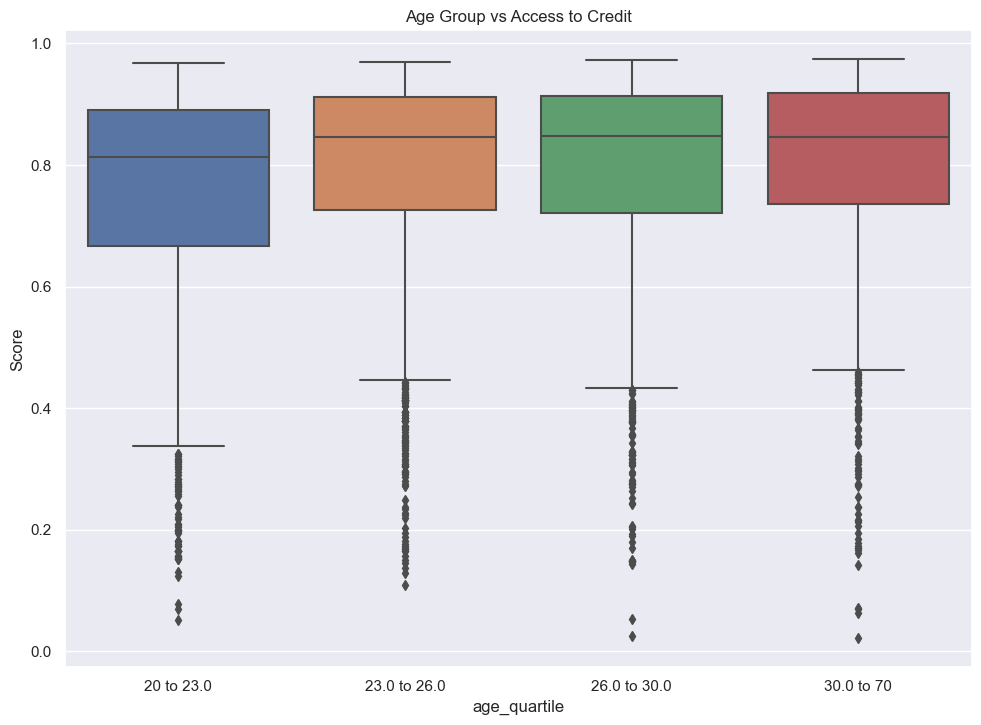

In [20]:
# age group vs access to credit (model evaluation of probability individual will repay)
# there is someone 144 years old - might get rid of that outlier
df_tc = df_tc[df_tc['person_age'] != 144]

# group individuals into quartiles by age
quartiles = df_tc['person_age'].quantile([0.25, 0.5, 0.75])
firstQuartile = f"{df_tc['person_age'].min()} to {quartiles[0.25]}"
secondQuartile = f"{quartiles[0.25]} to {quartiles[0.50]}"
thirdQuartile = f"{quartiles[0.50]} to {quartiles[0.75]}"
fourthQuartile = f"{quartiles[0.75]} to {df_tc['person_age'].max()}"

# separate individuals into quartiles
df_tc['age_quartile'] = pd.qcut(df_tc['person_age'], q = [0, 0.25, 0.5, 0.75, 1], labels = [firstQuartile, secondQuartile, thirdQuartile, fourthQuartile])

# plot
sns.boxplot(x=df_tc['age_quartile'], y=df_tc['probabilityPaid'])
plt.title('Age Group vs Access to Credit')
plt.ylabel('Score')

It seems that those who are younger are more likely to be denied credit. This could be due to the fact that younger people have less credit history and are more likely to default on a loan. Overall, there was not much of a different in access to credit from ages 23-70.

2. We will now look at if it is more difficult to get a loan in order to pay for medical expenses. Here, we will look at approval rate by loan type and the percent each type of loan was repaid.

In [21]:
# unencode loan intent
df_compare = df_tc.copy()
df_compare['loan_intent'] = encoder.inverse_transform(df_tc['loan_intent'])

# approval by loan type
df_compare['approved'] = df_compare['probabilityPaid'] > 0.53
approved = df_compare.groupby('loan_intent')['approved'].mean()
print(type(approved))
# repaid by loan type
df_compare['repaid'] = df_compare['loan_status'] == 0
repaid = df_compare.groupby('loan_intent')['repaid'].mean()

# formatting
comparison = pd.DataFrame({'approved': approved, 'repaid': repaid})
comparison.reset_index(inplace=True)
comparison

<class 'pandas.core.series.Series'>


,loan_intent,approved,repaid
0,DEBTCONSOLIDATION,0.884956,0.712389
1,EDUCATION,0.897109,0.832483
2,HOMEIMPROVEMENT,0.933442,0.750000
3,MEDICAL,0.876048,0.715750
4,PERSONAL,0.890782,0.779559
5,VENTURE,0.903527,0.853734


It seems that loans for medical expenses are approved at the lowest rate (although not by too much compared to other loan types). However, loans for medical expenses are repaid at one of the lowest rates. Meanwhile, loans for education or a business venture are more likely to be approved and also more likely to be repaid.

3. Finally, we will look at if a person's income level impacts how easy it is for them to access credit under our model. To do this, we will look at the score our model generally gives an individual by income level.

/Users/mihirsingh/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0, 0.5, 'Score')

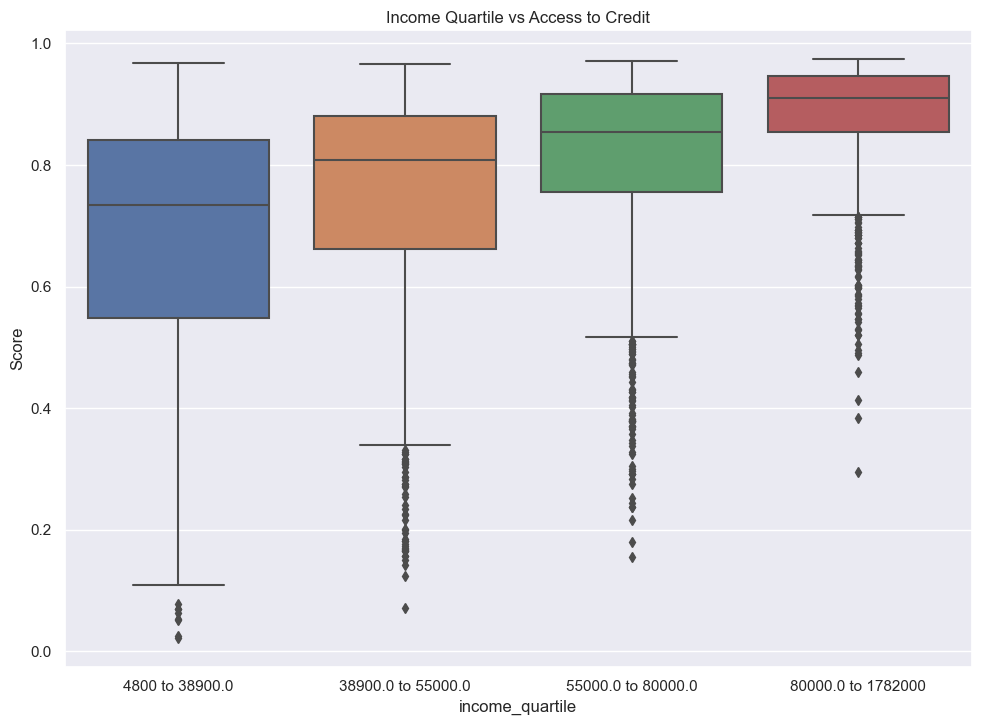

In [22]:
# income group vs access to credit
# group individuals into quartiles by age
quartiles = df_tc['person_income'].quantile([0.25, 0.5, 0.75])
firstQuartile = f"{df_tc['person_income'].min()} to {quartiles[0.25]}"
secondQuartile = f"{quartiles[0.25]} to {quartiles[0.50]}"
thirdQuartile = f"{quartiles[0.50]} to {quartiles[0.75]}"
fourthQuartile = f"{quartiles[0.75]} to {df_tc['person_income'].max()}"

# separate individuals into quartiles
df_tc['income_quartile'] = pd.qcut(df_tc['person_income'], q = [0, 0.25, 0.5, 0.75, 1], labels = [firstQuartile, secondQuartile, thirdQuartile, fourthQuartile])

# plot
sns.boxplot(x=df_tc['income_quartile'], y=df_tc['probabilityPaid'])
plt.title('Income Quartile vs Access to Credit')
plt.ylabel('Score')

We see that our model generally assigns higher scores to those with higher incomes.

## Discussion
Ultimately, I found that the threshold score was 0.53 and that the model was able to earn $7697437.56 in profit. I also found that the model tended to favor higher income individuals and was slightly biased against younger borrowers and borrowers seeking credit for medical reasons. We find that even with a simple formula for calculating bank profits, we were able to generate a large profit for the bank. From the bank's perspective, I believe that the model satisfies a test of sufficiency since it seems that the the features the model looks at like loan intent and income level are relevant to whether someone will repay their loan. This seems  fair from the bank's perspective because things like medical debt are riskier to repay and thus should be harder to get approved. However, from the borrower's perspective, this could be seen as unfair since people need to access credit for tremendous medical costs and it is not really their fault that they must get these treatments, so they are punished for something out of their control when they try to access credit. From this we see that what is fair and reasonable from one perspective may not be from another. With this in mind, one could argue that the model both satisfies and fails a narrow view of fairness since the bank might argue that with all things being equal - people are likely to get the same score. Meanwhile, a borrower might argue that loan-intent is not really a feature that should be used since people who are similar in every way except loan intent will probably receive different scores. It all from which perspective you evaluate the model and who you ask. I personally believe in a broader view of fairness that takes into account the implications of the model on the individual borrower and not just the bank. For this reason, I believe that the bank's model is not fair since people will need to access credit for medical loans and they are unfairly punished for having such a need. Medical loan borrowers can't control the fact that they need credit for medical expenses and thus should not be punished for it.

Finally, I learned how to choose an optimal threshold for my model as well as how to investigate the results of that decision.
